# Offset free nonlinear MPC

In [11]:
import do_mpc
from casadi import SX, vertcat
import numpy as np

def get_model():
    model_type = 'continuous'
    model = do_mpc.model.Model(model_type)

    # States
    h1 = model.set_variable(var_type='_x', var_name='h1')
    h2 = model.set_variable(var_type='_x', var_name='h2')

    # Input
    u1 = model.set_variable(var_type='_u', var_name='u1')
    u2 = model.set_variable(var_type='_u', var_name='u2')
    
    # Parameters
    A1 = 1
    A2 = 0.5
    k1 = 0.5
    k2 = 0.8
    
    delta_h = h1 - h2
    flow12 = k1 * SX.sign(delta_h) * SX.sqrt(SX.fabs(delta_h))
    
    # Differential equations
    dh1_dt = (-flow12 + u1)/A1
    dh2_dt =  (flow12 - k2 * (h2**0.5) + u2)/A2

    model.set_rhs('h1', dh1_dt)
    model.set_rhs('h2', dh2_dt)

    model.setup()

    return model


In [12]:
def get_mpc(model):
    mpc = do_mpc.controller.MPC(model)

    setup_mpc = {
        'n_horizon': 20,
        't_step': 1.0,
        'state_discretization': 'collocation',
        'collocation_type': 'radau',
        'collocation_deg': 2,
        'collocation_ni': 2,
        'store_full_solution': True,
    }

    mpc.set_param(**setup_mpc)

    # Objective: track h1 and h2 to their references
    weight_h1 = 5/0.79368273  # Weight for h1
    weight_h2 = 5/0.52258528  # Weight for h2
    h1_ref = 1.5     # Reference for h1
    h2_ref = 0.8     # Reference for h2

    mterm = (weight_h1 * (model.x['h1'] - h1_ref)**2 + weight_h2 * (model.x['h2'] - h2_ref)**2)*0
    lterm = weight_h1 * (model.x['h1'] - h1_ref)**2 + weight_h2 * (model.x['h2'] - h2_ref)**2

    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(u1=1/0.02223645, u2=1/0.08454784)  # Small penalty on input moves for both u1 and u2
    mpc.set_param(rterm_delta_u=True)  # penalize Δu instead of u 
    # Constraints
    mpc.bounds['lower', '_u', 'u1'] = 0.0
    mpc.bounds['upper', '_u', 'u1'] = 0.5
    mpc.bounds['lower', '_u', 'u2'] = 0.0
    mpc.bounds['upper', '_u', 'u2'] = 1.0

    # Setup
    mpc.setup()

    return mpc


In [13]:
import do_mpc

def get_simulator(model):
    simulator = do_mpc.simulator.Simulator(model)

    params_simulator = {
        't_step': 1
    }

    simulator.set_param(**params_simulator)

    simulator.setup()

    return simulator


In [14]:
import matplotlib.pyplot as plt
import numpy as np

class Visualizer:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.lines = []
        self.ax.set_xlabel('Time [s]')
        self.ax.set_ylabel('Tank heights')
        self.ax.grid()

    def update(self, data):
        h1 = data['_x']['h1']
        h2 = data['_x']['h2']
        t = data['_time']

        if not self.lines:
            self.lines.append(self.ax.plot(t, h1, label='h1')[0])
            self.lines.append(self.ax.plot(t, h2, label='h2')[0])
            self.ax.legend()
        else:
            self.lines[0].set_data(t, h1)
            self.lines[1].set_data(t, h2)

        self.ax.relim()
        self.ax.autoscale()

        plt.pause(0.01)


In [15]:
def main():
    global h1_history, h2_history, u_history
    model = get_model()
    mpc = get_mpc(model)
    simulator = get_simulator(model)
    #visualizer = Visualizer()

    x0 = np.array([0.5, 0.49999])  # Initial tank heights
    u0 = np.array([0.0348, 0.5316])
    mpc.x0 = x0
    mpc.u0 = u0
    simulator.x0 = x0

    mpc.set_initial_guess()

    n_steps = 100
    time_history = [0]
    h1_history = [x0[0].item()]
    h2_history = [x0[1].item()]
    u_history = [u0.flatten().tolist()]  # Include initial control inputs

    for k in range(1, n_steps + 1):
        u0 = mpc.make_step(x0)
        y_next = simulator.make_step(u0)

        time_history.append(k * 1)
        h1_history.append(x0[0].item())
        h2_history.append(x0[1].item())
        u_history.append(u0.flatten().tolist())  # Store control inputs

        x0 = y_next

        # data = {
        #     '_time': np.array(time_history),
        #     '_x': {
        #         'h1': np.array(h1_history),
        #         'h2': np.array(h2_history)
        #     }
        # }

        # visualizer.update(data)

    plt.show()

if __name__ == '__main__':
    main()


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1042
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      358

Total number of variables............................:      334
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:      282
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.4321815e+02 3.25e-02 1.36e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

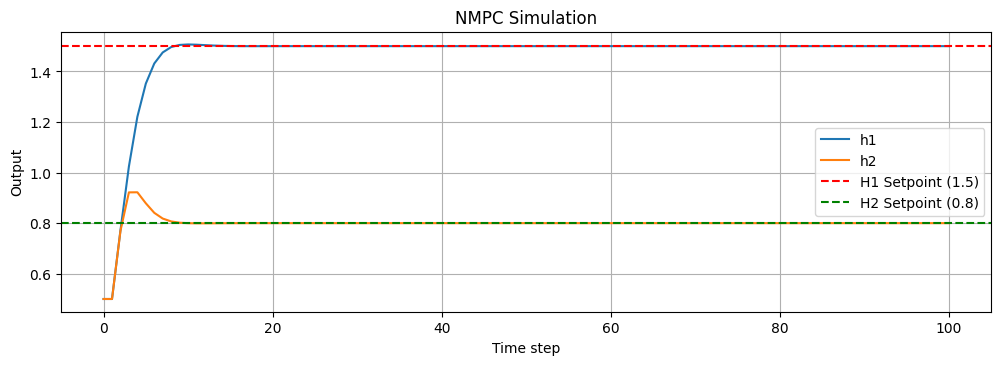

In [16]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(h1_history, label='h1')
plt.plot(h2_history, label='h2')
plt.axhline(y=1.5, color='r', linestyle='--', label='H1 Setpoint (1.5)')
plt.axhline(y=0.8, color='g', linestyle='--', label='H2 Setpoint (0.8)')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.title('NMPC Simulation')
plt.legend()
plt.grid(True)

In [17]:
u_history = np.array(u_history)

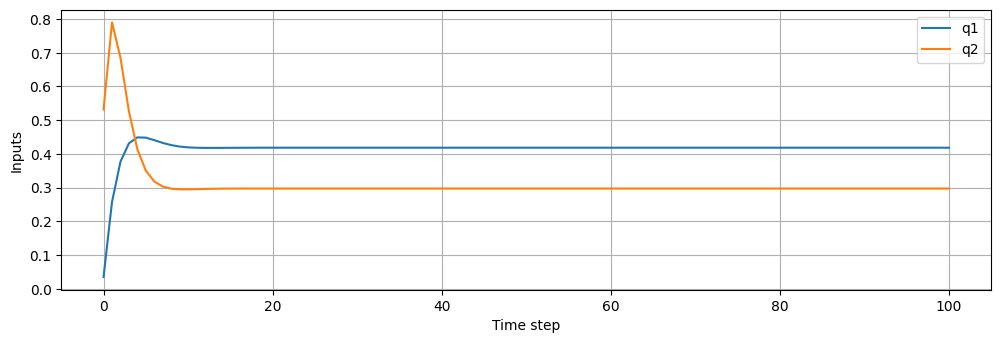

In [18]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(u_history.T[0], label='q1')
plt.plot(u_history.T[1], label='q2')
plt.xlabel('Time step')
plt.ylabel('Inputs')
plt.legend()
plt.grid(True) 

In [19]:
import joblib
scaler = joblib.load('data/scaler.pkl')
scalerU = joblib.load('data/scalerU.pkl')

In [21]:
# Compute the closed-loop value of the objective function
y_sim = scaler.transform(np.array([h1_history, h2_history]).T).T
u_sim = scalerU.transform(np.array(u_history).reshape(-1, 2)).T
y_setpoint = scaler.transform(np.array([1.5, 0.8]).reshape(1, -1)).flatten()
Qy = np.diag([5, 5])  # Weights for h1 and h2
Qu = np.diag([1, 1])  # Weights for u1 and u2

objective_value = 0
for k in range(100):
    y_diff = y_sim[:, k] - y_setpoint
    u_diff = u_sim[:, k] - u_sim[:, k-1] if k > 0 else np.zeros(2)
    objective_value += y_diff.T @ Qy @ y_diff 
    #objective_value += u_diff.T @ Qu @ u_diff
    #print(f"Objective value at step {k}: {objective_value}")
print(f"Closed-loop objective function value: {objective_value}")

Closed-loop objective function value: 20.38180412926839


In [22]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[0] - y_setpoint[0]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

First sustained convergence index: 8


In [23]:
e = 0.01  # Tolerance

in_band = np.abs(y_sim[1] - y_setpoint[1]) <= e

# Check for the first index where all subsequent values stay in the band
for i in range(len(y_sim[0])):
    if np.all(in_band[i:]):
        print("First sustained convergence index:", i)
        break
else:
    print("No sustained convergence found.")

First sustained convergence index: 8


In [91]:
scaler.scale_**2

array([0.78450391, 0.51157423])

In [92]:
y_sim[:,5]-y_setpoint

array([-0.16725468,  0.10982866])

In [93]:
y_setpoint

array([ 0.29135356, -0.22285209])

In [94]:
k=1
u_sim[:, k] - u_sim[:, k-1]

array([1.4925686 , 0.88846396])

In [95]:
u_sim

array([[-1.24436513,  0.24820347,  1.04878248,  1.41597288,  1.53299849,
         1.52778508,  1.47780127,  1.42297769,  1.37950754,  1.35074928,
         1.33442387,  1.32668309,  1.32401747,  1.32389067,  1.32474224,
         1.32575318,  1.32657924,  1.32713657,  1.32745886,  1.32761547,
         1.32767238,  1.3276783 ,  1.32766376,  1.32764509,  1.3276294 ,
         1.3276186 ,  1.32761225,  1.32760909,  1.32760789,  1.32760771,
         1.32760795,  1.32760829,  1.32760859,  1.3276088 ,  1.32760892,
         1.32760899,  1.32760901,  1.32760902,  1.32760901,  1.32760901,
         1.327609  ,  1.327609  ,  1.327609  ,  1.32760899,  1.32760899,
         1.32760899,  1.32760899,  1.32760899,  1.32760899,  1.32760899,
         1.32760899,  1.32760899,  1.32760899,  1.32760899,  1.32760899,
         1.32760899,  1.32760899,  1.32760899,  1.32760899,  1.32760899,
         1.32760899,  1.32760899,  1.32760899,  1.32760899,  1.32760899,
         1.32760899,  1.32760899,  1.32760899,  1.3